In my previous post, I explored the DrivenData competition "Machine Learning with a Heart" and decided how I'd like to transform the data. This post will step through transforming the data and produce output predictions for submission.

- [Load the data](#load-the-data)
- [Scaling](#scaling)
- [One-hot Encoding](#one-hot-encoding)
- [Model Training](#model-training)

# Load the Data

In [1]:
# import modules
import os

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, GridSearchCV, learning_curve, StratifiedKFold, validation_curve
from sklearn.preprocessing import LabelEncoder, StandardScaler
import seaborn as sns


# change current directory
os.chdir('../data')
DATA_DIR = os.getcwd()

# load the data
df_x = pd.read_csv(DATA_DIR + '/raw/train_values.csv')
df_y = pd.read_csv(DATA_DIR + '/raw/train_labels.csv')
df_x_test = pd.read_csv(DATA_DIR + '/raw/test_values.csv')

# Scaling
Now that the data is loaded we can start transforming the data to make it ready for modeling. The first step will be to standardize the numerical data using scikit-learn's `StandardScaler`.

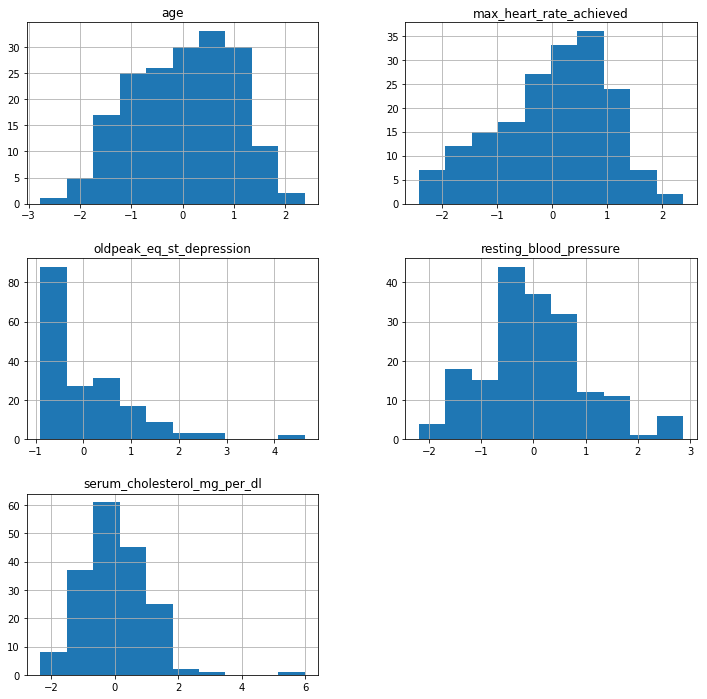

In [2]:
# columns to be scaled
cols_for_scaler = ['age', 'max_heart_rate_achieved', 'oldpeak_eq_st_depression', 'resting_blood_pressure', 'serum_cholesterol_mg_per_dl']

# sklearn standardization scaler
std_scaler = StandardScaler()
df_x[cols_for_scaler] = std_scaler.fit_transform(df_x[cols_for_scaler])
df_x_test[cols_for_scaler] = std_scaler.transform(df_x_test[cols_for_scaler])

# view the results
fig = df_x[cols_for_scaler].hist(figsize=[12, 12])

In [3]:
df_x[cols_for_scaler].describe()

,age,max_heart_rate_achieved,oldpeak_eq_st_depression,resting_blood_pressure,serum_cholesterol_mg_per_dl
count,1.800000e+02,1.800000e+02,1.800000e+02,1.800000e+02,1.800000e+02
mean,1.295260e-16,6.019876e-16,-1.973730e-17,4.835638e-16,4.440892e-17
std,1.002789e+00,1.002789e+00,1.002789e+00,1.002789e+00,1.002789e+00
min,-2.772773e+00,-2.430824e+00,-9.032069e-01,-2.199542e+00,-2.343694e+00
25%,-7.316875e-01,-7.946197e-01,-9.032069e-01,-6.668058e-01,-6.745333e-01
50%,2.029150e-02,1.143828e-01,-1.877955e-01,-7.729183e-02,-7.059193e-02
75%,7.722705e-01,7.620471e-01,5.276159e-01,5.122221e-01,6.094366e-01
max,2.383654e+00,2.386889e+00,4.641231e+00,2.870278e+00,5.987844e+00


From the table we can see that each distribution now has a mean of 0 and a  variance of approximately 1. It is also worth noting that these distributions don't perfectly match a Gaussian distribution. For now we will continue as is but in the future we can come back and think about other ways of scaling to see if it affects the model performance.

# One-hot Encoding
Now that the numerical data are scaled, we can focus on preparing the categorical and ordinal data. The column `thal` will first need to be converted from string labels to integers through the use of scikit-learn's `LabelEncoder` before we use pandas' `get_dummies()` to one-hot encode the non-numerical columns.

In [4]:
# cols for label and one-hot encoding
label_enc_cols = ['thal']
one_hot_cols = ['slope_of_peak_exercise_st_segment', 'num_major_vessels', 'chest_pain_type', 'resting_ekg_results', 'sex', 'thal']

# sklearn label encoder
# fit to provided values from competition in case sample
# doesn't contain all possibilities
label_encoder = LabelEncoder()
label_encoder.fit(['normal', 'fixed_defect', 'reversible_defect'])

# transform data
df_x[label_enc_cols] = label_encoder.transform(df_x[label_enc_cols].values.ravel())
df_x_test[label_enc_cols] = label_encoder.transform(df_x_test[label_enc_cols].values.ravel())

# one-hot encode using get_dummies
encoded = pd.get_dummies(pd.concat([df_x, df_x_test], axis=0), 
                         columns=one_hot_cols,
                         drop_first=True)

df_x = encoded.iloc[:df_x.shape[0], :]
df_x_test = encoded.iloc[df_x.shape[0]:, :]

In [5]:
df_x.head()

,patient_id,resting_blood_pressure,fasting_blood_sugar_gt_120_mg_per_dl,serum_cholesterol_mg_per_dl,oldpeak_eq_st_depression,age,max_heart_rate_achieved,exercise_induced_angina,slope_of_peak_exercise_st_segment_2,slope_of_peak_exercise_st_segment_3,...,num_major_vessels_2,num_major_vessels_3,chest_pain_type_2,chest_pain_type_3,chest_pain_type_4,resting_ekg_results_1,resting_ekg_results_2,sex_1,thal_1,thal_2
0,0z64un,-0.195195,0,1.118269,-0.903207,-1.053964,0.932485,0,0,0,...,0,0,1,0,0,0,1,1,1,0
1,ryoo3j,-1.256320,0,-0.669778,0.527616,-0.087134,0.387084,0,1,0,...,0,0,0,1,0,0,0,0,1,0
2,yt1s1x,-0.372049,0,1.042182,-0.903207,2.383654,0.568884,1,0,0,...,0,1,0,0,1,0,1,1,1,0
3,l2xjde,1.219639,0,-0.498582,-0.903207,-1.591092,1.432436,0,0,0,...,0,0,0,0,1,0,0,1,0,1
4,oyt4ek,2.752375,0,0.395442,2.852703,0.449994,-0.203768,0,0,1,...,0,0,0,0,0,0,1,1,0,1


In [6]:
df_x_test.head()

,patient_id,resting_blood_pressure,fasting_blood_sugar_gt_120_mg_per_dl,serum_cholesterol_mg_per_dl,oldpeak_eq_st_depression,age,max_heart_rate_achieved,exercise_induced_angina,slope_of_peak_exercise_st_segment_2,slope_of_peak_exercise_st_segment_3,...,num_major_vessels_2,num_major_vessels_3,chest_pain_type_2,chest_pain_type_3,chest_pain_type_4,resting_ekg_results_1,resting_ekg_results_2,sex_1,thal_1,thal_2
0,olalu7,2.280764,0,0.737834,-0.724354,0.449994,0.432534,0,1,0,...,0,0,0,0,0,0,1,1,0,1
1,z9n6mx,0.394319,0,-1.259453,0.348763,-2.128220,1.477887,0,0,0,...,0,0,0,0,1,0,0,0,1,0
2,5k4413,-0.666806,0,-1.373584,1.332454,-1.268815,-1.340021,1,1,0,...,0,0,0,0,1,0,1,1,0,1
3,mrg7q5,-1.727931,0,1.308487,-0.903207,0.557419,0.477984,0,0,0,...,0,0,0,1,0,0,0,0,1,0
4,uki4do,0.394319,0,-1.582823,2.316144,0.664845,-1.112771,1,1,0,...,0,0,0,0,1,0,1,1,1,0


The output above shows how one-hot encoding has expanded the number of features to 21. We included the option `drop_first=True` to reduce the number of features and to prevent collinearity between features. This option drops one of the possible one-hot encoded values because it can be implied by the remaining values for the base feature.

With all the data transformed, we can now start modeling.

# Model Training
We'll use logistic regression for our model since it is an interpretabile model and because our dataset is small. There are few hyperparameters to tune so training the model should be fairly quick. To start, we can do a Grid Search to try various combinations of our possible hyperparameters and determine which ones provide the best score.

In [7]:
# create numpy arrays from the training data
X = df_x.drop('patient_id', axis=1).values
y = df_y.drop('patient_id', axis=1).values.ravel()

# set random_state variable for reproducibility
rs = 10

# gridsearch for logistic regression parameters
param_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
param_grid = [{'C': param_range, 'penalty': ['l1', 'l2']}]
log_reg = LogisticRegression(random_state=rs, solver='liblinear', C=1)
gs = GridSearchCV(estimator=log_reg,
                  param_grid=param_grid,
                  scoring='accuracy',
                  cv=10, n_jobs=2)
gs = gs.fit(X, y)
print('Best score: {}'.format(gs.best_score_))
print('Best params: {}'.format(gs.best_params_))

Best score: 0.8333333333333334
Best params: {'C': 100.0, 'penalty': 'l1'}


In [8]:
# Repeat gridsearch with narrower region
param_range = [25.0, 50.0, 75.0, 100.0, 125.0, 150.0, 175.0, 200.0]
param_grid = [{'C': param_range, 'penalty': ['l1', 'l2']}]
log_reg = LogisticRegression(random_state=rs, 
                             solver='liblinear',
                             C=1,
                             penalty='l1')
gs = GridSearchCV(estimator=log_reg,
                  param_grid=param_grid,
                  scoring='accuracy',
                  cv=10, n_jobs=2)
gs = gs.fit(X, y)
print('Best score: {}'.format(gs.best_score_))
print('Best params: {}'.format(gs.best_params_))

Best score: 0.8333333333333334
Best params: {'C': 25.0, 'penalty': 'l1'}


The results of the grid search show that a model with `l1` penalty and a C of 25, where C is the inverse of the regularization strength, yields the best accuracy score.

To understand our model more, we can also look at the learning and validation curves.

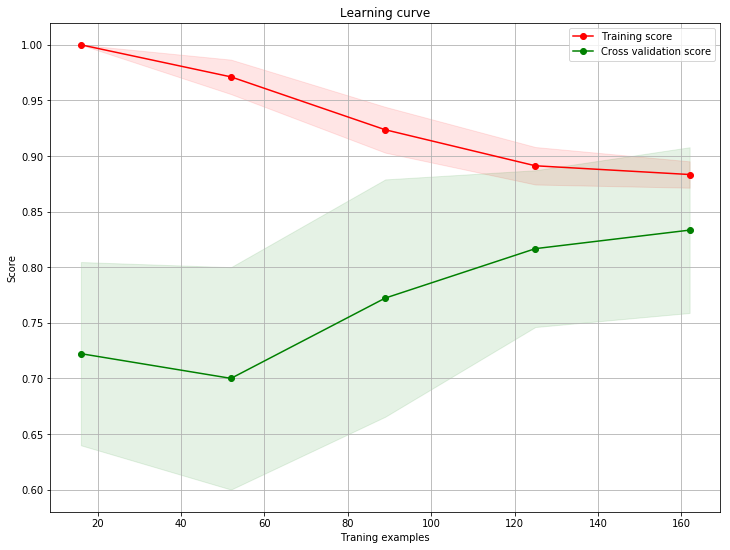

In [13]:
plt.rcParams['figure.figsize'] = [12, 9]
plt.title('Learning curve')
plt.xlabel('Traning examples')
plt.ylabel('Score')
train_sizes, train_scores, test_scores = learning_curve(log_reg,
                                                        X,
                                                        y,
                                                        cv=10,
                                                        n_jobs=2)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
plt.grid()

plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color='r')
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1,
                 color='g')
plt.plot(train_sizes, train_scores_mean, 'o-', color='r',
         label='Training score')
plt.plot(train_sizes, test_scores_mean, 'o-', color='g',
         label='Cross validation score')
plt.legend(loc='best')
plt.show()

In the above figure, we can see that as the number of training examples grows, the training and cross validation scores come closer together. This convergence is a good sign that we aren't under or overfitting our data.

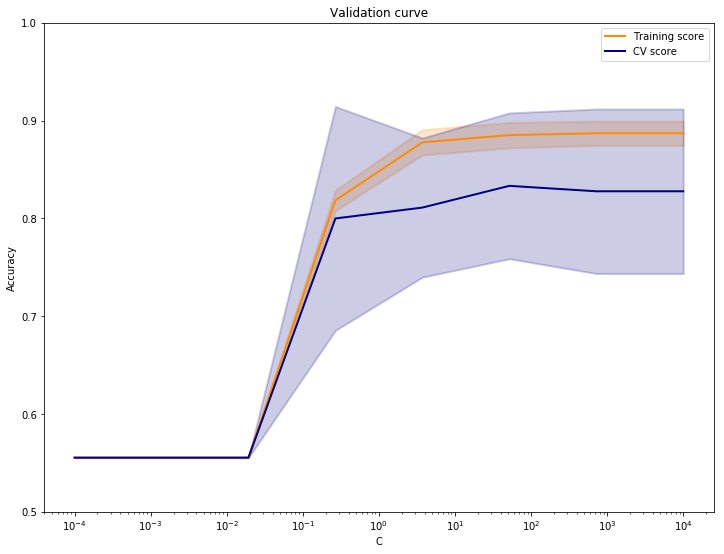

In [17]:
# validation curve for various C values
param_range = np.logspace(-4, 4, 8)
log_reg = LogisticRegression(random_state=rs,
                             solver='liblinear',
                             C=25,
                             penalty='l1')
kfold = StratifiedKFold(n_splits=10, random_state=rs).split(X, y)
train_scores, test_scores = validation_curve(log_reg,
                                             X,
                                             y,
                                             param_name='C',
                                             param_range=param_range,
                                             cv=kfold,
                                             scoring='accuracy',
                                             n_jobs=1)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.rcParams['figure.figsize'] = [12, 9]
plt.title('Validation curve')
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.ylim(0.5, 1.0)
lw = 2
plt.semilogx(param_range, train_scores_mean, label='Training score',
             color='darkorange', lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color='darkorange', lw=lw)
plt.semilogx(param_range, test_scores_mean, label='CV score',
             color='navy', lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color='navy', lw=lw)
plt.legend(loc='best')
plt.show()

The validation curve shows the accuracy of the training and validation sets as a function of the C regularization parameter. We can see that if we have too small of a parameter, our model is sparsified too severely and does not perform well. We can also see that our model plateaus around the value C=25 which grid search provided us.

We can continue by running a 10-fold cross validation check on our data.

In [11]:
# cross validation with 10 k-folds
log_reg = LogisticRegression(random_state=rs,
                             solver='liblinear',
                             C=25,
                             penalty='l1')
kfold = StratifiedKFold(n_splits=10, random_state=rs).split(X, y)

scores = []
for k, (train, test) in enumerate(kfold):
    log_reg.fit(X[train], y[train])
    score = log_reg.score(X[test], y[test])
    scores.append(score)
    print('Score: {}'.format(score))
    
print('Average score: {}'.format(np.array(scores).mean()))

Score: 0.8333333333333334
Score: 0.7222222222222222
Score: 0.8888888888888888
Score: 0.7777777777777778
Score: 0.8888888888888888
Score: 0.9444444444444444
Score: 0.7777777777777778
Score: 0.7222222222222222
Score: 0.8888888888888888
Score: 0.8888888888888888
Average score: 0.8333333333333334


We can see that the scores are fairly steady for each of the cross-validation tests. The model is now ready to be fully trained and submitted to the competition.

In [12]:
# train using all the data
log_reg = LogisticRegression(random_state=rs,
                             solver='liblinear',
                             C=25,
                             penalty='l1')
log_reg.fit(X, y)
X_test = df_x_test.drop('patient_id', axis=1).values
y_pred = log_reg.predict_proba(X_test)

# create submission CSV
df_submit = pd.DataFrame(data=df_x_test['patient_id'], columns=['patient_id'])
df_submit['heart_disease_present'] = y_pred[:,1]
df_submit.to_csv('../models/sub_01.csv', index=False)

This model produced a log loss score of 0.30606 upon submission which is 7th out of about 700 participants. At the time of writing, first place has a log loss of 0.27887. For a quick first pass analysis, this is very good.

For anyone interested, this is an endless competition. It is meant for practicing and to get new users accustomed to the competitions.